In [17]:
%matplotlib inline

# Import required packages
import os
import json
import numpy as np
from tqdm import tqdm
from collections import defaultdict
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

---
Training a neural recurrent language model on Wikitext-2.

#### Load data

In [18]:
def load_wikitext(filename='wikitext2-sentencized.json'):    
    datasets = json.load(open(filename, 'r'))
    for name in datasets:
        datasets[name] = [x.split() for x in datasets[name]]
    vocab = list(set([t for ts in datasets['train'] for t in ts]))      
    print("Vocab size: %d" % (len(vocab)))
    return datasets, vocab

def perplexity(model, sequences):
    n_total = 0
    logp_total = 0
    for sequence in sequences:
        logp_total += model.sequence_logp(sequence)
        n_total += len(sequence) + 1  
    ppl = 2 ** (- (1.0 / n_total) * logp_total)  
    return ppl

In [5]:
datasets, vocab = load_wikitext()

Vocab size: 33175


In [8]:
datasets['train'][0]

['Valkyria',
 'of',
 'the',
 'Battlefield',
 '3',
 ')',
 ',',
 'commonly',
 'referred',
 'to',
 'as',
 'Valkyria',
 'Chronicles',
 'III',
 'outside',
 'Japan',
 ',',
 'is',
 'a',
 'tactical',
 'role',
 '@-@',
 'playing',
 'video',
 'game',
 'developed',
 'by',
 'Sega',
 'and',
 'Media.']

In [9]:
class Dictionary(object): #maps words to indices
    def __init__(self, datasets, include_valid=False):
        self.tokens = []
        self.ids = {}
        self.counts = {}
        
        # add special tokens
        self.add_token('<bos>') #beginning of sentence
        self.add_token('<eos>') #end of sentence
        self.add_token('<pad>')
        self.add_token('<unk>') #unknown
        
        for line in tqdm(datasets['train']):
            for w in line:
                self.add_token(w)
                    
        if include_valid is True:
            for line in tqdm(datasets['valid']):
                for w in line:
                    self.add_token(w)
                            
    def add_token(self, w):
        if w not in self.tokens:
            self.tokens.append(w)
            _w_id = len(self.tokens) - 1
            self.ids[w] = _w_id
            self.counts[w] = 1
        else:
            self.counts[w] += 1

    def get_id(self, w):
        return self.ids[w]
    
    def get_token(self, idx):
        return self.tokens[idx]
    
    def decode_idx_seq(self, l):
        return [self.tokens[i] for i in l]
    
    def encode_token_seq(self, l):
        return [self.ids[i] if i in self.ids else self.ids['<unk>'] for i in l]
    
    def __len__(self):
        return len(self.tokens)

In [10]:
dataset_dict = Dictionary(datasets, include_valid=True)

100%|█████████████████████████████████████| 8464/8464 [00:05<00:00, 1621.38it/s]


In [11]:
def tokenize_dataset(datasets, dictionary, ngram_order=2): #substitute words with numbers. Sometimes can include splitting strings, dealing with punctuation and symbols.
    tokenized_datasets = {}
    for split, dataset in datasets.items():
        _current_dictified = []
        for l in tqdm(dataset):
            l = ['<bos>']*(ngram_order-1) + l + ['<eos>']
            encoded_l = dictionary.encode_token_seq(l)
            _current_dictified.append(encoded_l)
        tokenized_datasets[split] = _current_dictified
        
    return tokenized_datasets

In [12]:
tokenized_datasets = tokenize_dataset(datasets, dataset_dict)

100%|███████████████████████████████████| 9708/9708 [00:00<00:00, 279616.43it/s]


In [16]:
print(tokenized_datasets['train'][0])

[0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 4, 15, 16, 17, 18, 10, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 1]


In [21]:
class TensoredDataset(Dataset):
    def __init__(self, list_of_lists_of_tokens):
        self.input_tensors = []
        self.target_tensors = []
        
        for sample in list_of_lists_of_tokens:
            self.input_tensors.append(torch.tensor([sample[:-1]], dtype=torch.long))
            self.target_tensors.append(torch.tensor([sample[1:]], dtype=torch.long))
    
    def __len__(self):
        return len(self.input_tensors)
    
    def __getitem__(self, idx):
        # return a (input, target) tuple
        return (self.input_tensors[idx], self.target_tensors[idx])

In [22]:
tokenized_datasets = tokenize_dataset(datasets, dataset_dict)
tensor_dataset = {}

for split, listoflists in tokenized_datasets.items():
    tensor_dataset[split] = TensoredDataset(listoflists)
    
# check the first example
tensor_dataset['train'][0]

100%|███████████████████████████████████| 9708/9708 [00:00<00:00, 279319.12it/s]


(tensor([[ 0,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  4, 15, 16, 17, 18, 10,
          19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]]),
 tensor([[ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  4, 15, 16, 17, 18, 10, 19,
          20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,  1]]))

In [23]:
def pad_list_of_tensors(list_of_tensors, pad_token):
    max_length = max([t.size(-1) for t in list_of_tensors])
    padded_list = []
    
    for t in list_of_tensors:
        padded_tensor = torch.cat([t, torch.tensor([[pad_token]*(max_length - t.size(-1))], dtype=torch.long)], dim = -1)
        padded_list.append(padded_tensor)
        
    padded_tensor = torch.cat(padded_list, dim=0)
    
    return padded_tensor

def pad_collate_fn(batch):
    # batch is a list of sample tuples
    input_list = [s[0] for s in batch]
    target_list = [s[1] for s in batch]
    
    pad_token = dataset_dict.get_id('<pad>')
    #pad_token = 2
    
    input_tensor = pad_list_of_tensors(input_list, pad_token)
    target_tensor = pad_list_of_tensors(target_list, pad_token)
    
    return input_tensor, target_tensor

In [24]:
wikitext_loaders = {}

batch_size = 128

for split, dataset in tensor_dataset.items():
    wikitext_loaders[split] = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_fn)

#### Model + Training

In [25]:
class LSTMLanguageModel(nn.Module):
    """
    This model combines embedding, lstm and projection layer into a single model
    """
    def __init__(self, options):
        super().__init__()
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], 
                                   embedding_dim=options['embedding_dim'],
                                   padding_idx=options['padding_idx'])
        self.lstm = nn.LSTM(options['input_size'], options['hidden_size'], 
                            options['num_layers'], dropout=options['lstm_dropout'], 
                            batch_first=True)
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
        
    def forward(self, encoded_input_sequence):
        embeddings = self.lookup(encoded_input_sequence)        
        lstm_outputs = self.lstm(embeddings)                        
        logits = self.projection(lstm_outputs[0])
        
        return logits

#### Early Stopping
(Reference: https://github.com/Bjarten/early-stopping-pytorch)

In [26]:
class EarlyStopping:
    def __init__(self, options, max_patience=7, verbose=False, path='drive/MyDrive/Colab files nyu/wikitext_lstm_lm.pt'):
        self.max_patience = max_patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.path = path
        self.options = options
    def __call__(self, val_loss, loss_cache, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, loss_cache, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, loss_cache, model)
            self.counter = 0
    def save_checkpoint(self, val_loss, loss_cache, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save({
        'options': self.options,
        'loss_cache': loss_cache,
        'model_dict': model.state_dict()}, self.path)
        self.val_loss_min = val_loss

In [30]:


load_pretrained = False

num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

if load_pretrained:
    if not os.path.exists('wikitext_lstm_lm_4.pt'):
        raise EOFError('Download pretrained model!')
    
    model_dict = torch.load('wikitext_lstm_lm_4.pt', map_location=current_device)
    model_dict['model_dict'] = OrderedDict([(key.replace('module.',''), val) for key,val in model_dict['model_dict'].items()])
    
    
    options = model_dict['options']
    model = LSTMLanguageModel(options).to(current_device)
    model.load_state_dict(model_dict['model_dict'])
    
      

    # model_dict = torch.load('wikitext_lstm_lm.pt', map_location=current_device)
    
    # options = model_dict['options']
    # model = LSTMLanguageModel(options).to(current_device)
    # model.load_state_dict(model_dict['model_dict'])
    
else:
    embedding_size = 256
    hidden_size = 512
    num_layers = 3
    lstm_dropout = 0.3

    options = {
        'num_embeddings': len(dataset_dict),
        'embedding_dim': embedding_size,
        'padding_idx': dataset_dict.get_id('<pad>'),
        'input_size': embedding_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'lstm_dropout': lstm_dropout,
    }

    model = LSTMLanguageModel(options).to(current_device)

    model = nn.DataParallel(model)

lr = 0.01
momentum = 0.999
max_patience = 5
epochs = 20

criterion = nn.CrossEntropyLoss(ignore_index=dataset_dict.get_id('<pad>'))

model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(model_parameters, lr=lr, momentum = momentum)

In [ ]:
plot_cache = []

early_stopping = EarlyStopping(options,max_patience=max_patience, verbose=True)

for epoch_number in range(epochs):
    avg_loss=0
    if not load_pretrained:
        # do train
        model.train()
        train_log_cache = []
        for i, (inp, target) in enumerate(wikitext_loaders['train']):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)
            
            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            
            loss.backward()
            optimizer.step()
            
            train_log_cache.append(loss.item())
            
            if i % 100 == 0:
                avg_loss = sum(train_log_cache)/len(train_log_cache)
                print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
                train_log_cache = []
            
    #do valid
    valid_losses = []
    model.eval()
    with torch.no_grad():
        for i, (inp, target) in enumerate(wikitext_loaders['valid']):
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            valid_losses.append(loss.item())
        avg_val_loss = sum(valid_losses) / len(valid_losses)
        print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number+1, avg_val_loss, prec=4))
        
    plot_cache.append((avg_loss, avg_val_loss))
    
    if load_pretrained:
        break
        
    early_stopping(avg_val_loss, plot_cache, model)
        
    if early_stopping.early_stop:
        print("Early stopping")
        break

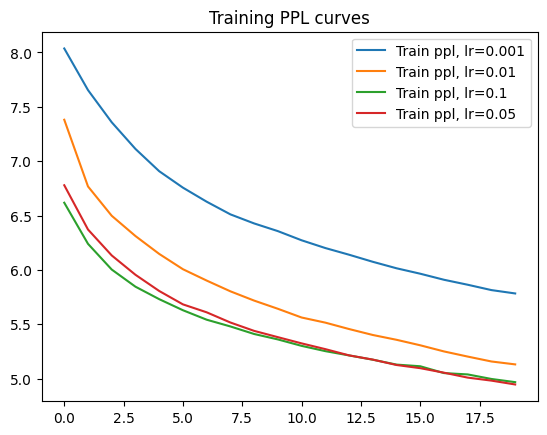

In [35]:
epochs = np.array(list(range(len(plot_cache_1))))
plt.plot(epochs, [i[0] for i in plot_cache_1], label='Train ppl, lr=0.001')
plt.plot(epochs, [i[0] for i in plot_cache_2], label='Train ppl, lr=0.01')
plt.plot(epochs, [i[0] for i in plot_cache_3], label='Train ppl, lr=0.1')
plt.plot(epochs, [i[0] for i in plot_cache_4], label='Train ppl, lr=0.05')

plt.legend()
plt.title('Training PPL curves')
plt.show()

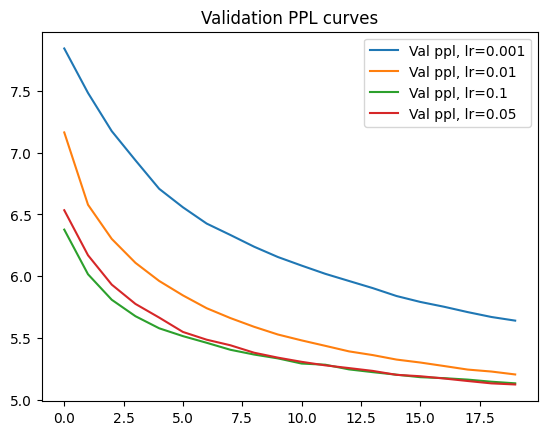

In [36]:
epochs = np.array(list(range(len(plot_cache_1))))
plt.plot(epochs, [i[1] for i in plot_cache_1], label='Val ppl, lr=0.001')
plt.plot(epochs, [i[1] for i in plot_cache_2], label='Val ppl, lr=0.01')
plt.plot(epochs, [i[1] for i in plot_cache_3], label='Val ppl, lr=0.1')
plt.plot(epochs, [i[1] for i in plot_cache_4], label='Val ppl, lr=0.05')

plt.legend()
plt.title('Validation PPL curves')
plt.show()

In [37]:

import umap
import matplotlib.pyplot as plt

def umap_plot(weight_matrix, word_ids, words):
    """Run UMAP on the entire Vxd `weight_matrix` (e.g. model.lookup.weight or model.projection.weight),
    And plot the points corresponding to the given `word_ids`. """
    reduced = umap.UMAP(min_dist=0.0001).fit_transform(weight_matrix.detach().cpu().numpy())
    plt.figure(figsize=(10,10))

    to_plot = reduced[word_ids, :]
    plt.scatter(to_plot[:, 0], to_plot[:, 1])
    for i, word_id in enumerate(word_ids):
        current_point = to_plot[i]
        plt.annotate(words[i], (current_point[0], current_point[1]))

    plt.grid()
    plt.show()

In [38]:
def cosine_similarity(tensor_1, tensor_2):
    cos_sim = torch.dot(tensor_1, tensor_2)/(torch.norm(tensor_1)*torch.norm(tensor_2))
    return cos_sim.item()

#### Word similarity 


In [39]:
weight_matrix = model_4.projection.weight

In [42]:
words = ['discovered','need','doing','create']
word_ids = [dataset_dict.get_id(word) for word in words]

final_words = []
final_word_ids = []

for i in word_ids:
    cos_sim_i = np.array([cosine_similarity(weight_matrix[i],emb_x) for emb_x in weight_matrix])
    max_i = [ind for ind in np.argpartition(cos_sim_i,-12)[-12:] if ind!=2 and ind!=i]
    max_sim_words = [dataset_dict.get_token(x) for x in max_i]
    min_i = [ind for ind in np.argpartition(cos_sim_i,10)[:10] if ind!=2]
    min_sim_words = [dataset_dict.get_token(x) for x in min_i]
    final_words += max_sim_words + min_sim_words
#     final_words.append(min_sim_words)
    final_word_ids += max_i + min_i
#     final_word_ids.append(min_i)
    print("Word: ",dataset_dict.get_token(i))
    print("Closest Words: ",max_sim_words)
    print("Furthest Words: ",min_sim_words)
    print()

Word:  discovered
Closest Words:  ['offered', 'granted', 'supported', 'created', 'launched', 'presented', 'founded', 'introduced', 'observed', 'conducted', 'issued']
Furthest Words:  ['secrecy', 'searing', 'ghettos', 'waterfront', 'postwar', 'initiation', 'Cosmos', 'poetical', 'entropy', 'heroism']

Word:  need
Closest Words:  ['deal', 'hold', 'help', 'practice', 'mean', 'turn', 'search', 'change', 'look', 'matter', 'question']
Furthest Words:  ['P.J.', 'Rural', 'Olga', 'McLeish', 'Brick', 'Ready', 'Bandai', 'Rimmer', 'Collymore', 'Abdullahi']

Word:  doing
Closest Words:  ['exactly', 'your', 'something', 'looking', 'keeping', 'studying', 'our', 'my', 'getting', 'trying', 'going']
Furthest Words:  ['diaspora', 'agglomeration', 'Archdiocese', 'Overseas', 'Tegetthoff', 'Mycological', 'Curriculum', 'Nationalists', 'Kingdoms', 'Tribunal']

Word:  create
Closest Words:  ['meet', 'produce', 'develop', 'allow', 'avoid', 'continue', 'bring', 'provide', 'keep', 'prevent', 'give']
Furthest Words

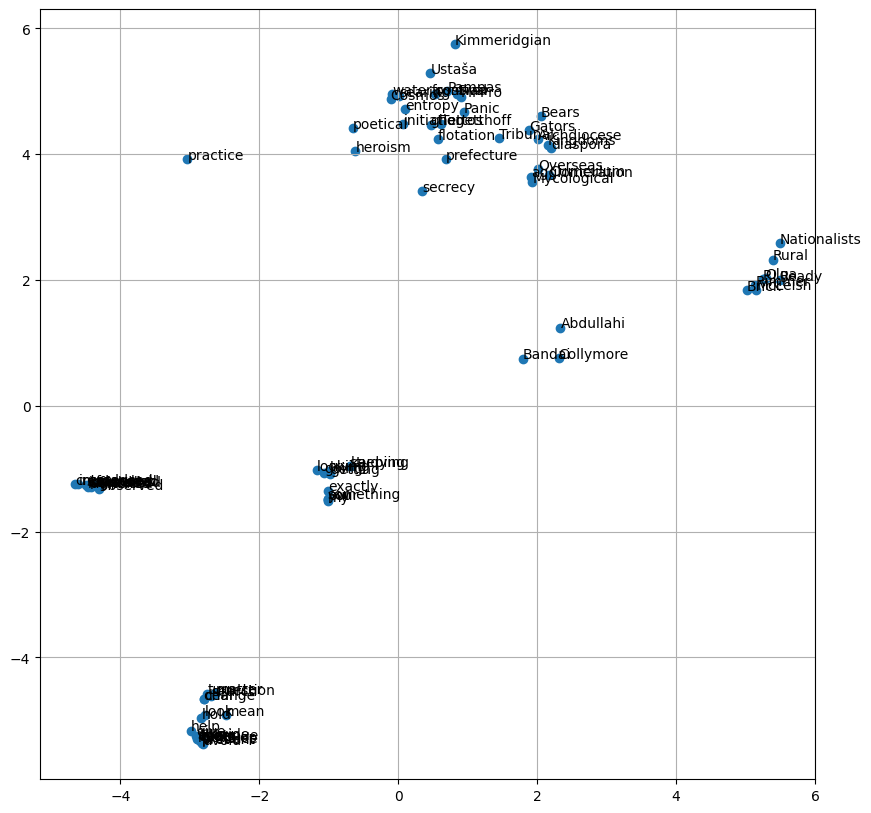

In [43]:
umap_plot(weight_matrix, final_word_ids, final_words)

#### Sampling

In [44]:
def sample_sentence(model):
    res = [0]
    end_tensor = torch.tensor([[1]],dtype=torch.int)
    softmax = nn.Softmax(dim=1)
    log_softmax = nn.LogSoftmax(dim=1)
    log_prob = 0
    state = (torch.zeros(model.lstm.num_layers, 1, model.lstm.hidden_size), 
             torch.zeros(model.lstm.num_layers, 1, model.lstm.hidden_size))
    inp = torch.tensor([[0]],dtype=torch.int)
    while(inp != end_tensor):
        out,state = model.lstm(model.lookup(inp),state)
        proj_out = model.projection(out.reshape(1,-1))
        p = softmax(proj_out)
        lp = log_softmax(proj_out)
        inp = torch.multinomial(p,1)
        log_prob += lp[0][inp.item()].item()
        res.append(inp.item())
    return res,log_prob/(len(res)-1)

In [45]:
total_log_prob = 0
sampled_sentences = []
for i in range(1000):
    sent,lp = sample_sentence(model_4)
    total_log_prob += lp
    sampled_sentences.append(sent)
total_log_prob/1000

-5.122176637729544

In [60]:
from random import sample

valid_list = [sentence for batch in wikitext_loaders['valid'] for sentence in batch[0]]
valid_list = [[ind.item() for ind in sentence if ind != 2] for sentence in valid_list]

sampled_valid_list = sample(valid_list,1000)

In [61]:
avg_sampled_len = 0
avg_valid_len = 0
for sentence in sampled_sentences:
    avg_sampled_len += len(sentence)
for sentence in sampled_valid_list:
    avg_valid_len += len(sentence)
    
print("avg_lengths(sampled sentences,validation sentences): ",avg_sampled_len/1000,avg_valid_len/1000)

avg_lengths(sampled sentences,validation sentences):  26.744 23.729


In [68]:
toks_sampled = [tok for sentence in sampled_sentences for tok in sentence]
toks_val = [tok for sentence in sampled_valid_list for tok in sentence]
unique_toks_sampled = set(toks_sampled)
unique_toks_val = set(toks_val)

print("No. of unique Tokens in sampled sentences: ", len(unique_toks_sampled))
print("No. of unique Tokens in validation sentences: ", len(unique_toks_val))

No. of unique Tokens in sampled sentences:  6584
No. of unique Tokens in validation sentences:  4896


#### 3.4 Example samples (3 pts)

In [48]:
sentences = sample(sampled_sentences,3)
sentences = [[dataset_dict.get_token(ind) for ind in sentence] for sentence in sentences]

In [56]:
print(sentences[0])

['<bos>', 'The', 'MLB', 'Trade', 'Temple', 'General', 'projection', '9', 'pipeline', 'of', 'the', 'national', 'version', 'of', 'RedOctane', 'and', 'try', 'despite', 'their', 'commercial', 'series', 'apart', 'forth', 'out', '.', '<eos>']


In [54]:
print(sentences[1])

['<bos>', 'The', 'song', 'was', 'viewed', 'by', 'a', 'Taoist', 'philosopher', 'droplets', ',', 'based', 'on', 'Super', 'Young', 'Stories', ',', 'with', 'restructuring', 'content', 'later', 'in', '2009', 'Building', ',', 'burrowing', 'in', '1951', ',', '1960', ',', '2003', 'and', 'grain', '.', '<eos>']


In [55]:
print(sentences[2])

['<bos>', 'The', 'entire', 'manufacturer', 'was', 'to', 'direct', 'tactical', 'hearings', 'with', 'him', ',', 'and', 'the', 'gully', 'was', '<unk>', '<unk>', 'for', 'around', 'their', 'own', '.', '<eos>']
